In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gurobipy import Model, GRB, quicksum

df_distances = pd.read_excel(f'/home/guest/Bureau/malek/sdp/sdp_project/data/distances.xlsx', sheet_name=0, header=None)

distances = df_distances.iloc[2:, 2:].to_numpy()
print(distances)

[[16.16 24.08 24.32 21.12]
 [19.0 26.47 27.24 17.33]
 [25.29 32.49 33.42 12.25]
 [0.0 7.93 8.31 36.12]
 [3.07 6.44 7.56 37.37]
 [1.22 7.51 8.19 36.29]
 [2.8 10.31 10.95 33.5]
 [2.87 5.07 5.67 38.8]
 [3.8 8.01 7.41 38.16]
 [12.35 4.52 4.35 48.27]
 [11.11 3.48 2.97 47.14]
 [21.99 22.02 24.07 39.86]
 [8.82 3.3 5.36 43.31]
 [7.93 0 2.07 43.75]
 [9.34 2.25 1.11 45.43]
 [8.31 2.07 0.0 44.43]
 [7.31 2.44 1.11 43.43]
 [7.55 0.75 1.53 43.52]
 [11.13 18.41 19.26 25.4]
 [17.49 23.44 24.76 23.21]
 [11.03 18.93 19.28 25.43]
 [36.12 43.75 44.43 0.0]]


In [3]:
df_workloads = pd.read_csv(f'/home/guest/Bureau/malek/sdp/sdp_project/data/bricks_index_values.csv')

workloads = df_workloads['index_value'].to_numpy()
print(workloads)

[0.1609 0.1164 0.1026 0.1516 0.0939 0.132  0.0687 0.093  0.2116 0.2529
 0.0868 0.0828 0.0975 0.8177 0.4115 0.3795 0.071  0.0427 0.1043 0.0997
 0.1698 0.2531]


In [4]:
# Current assignment (c_ij)
current_assignment = np.zeros((22, 4))
current_assignment[[0, 1, 2, 3, 4], 0] = 1
current_assignment[[5, 6, 7, 8], 1] = 1
current_assignment[[9, 10, 11, 12, 13], 2] = 1
current_assignment[[14, 15, 16, 17, 18, 19, 20, 21], 3] = 1

In [12]:
workload_min = 0.8
workload_max = 1.2
num_bricks = 22
num_sales_reps = 4

In [19]:
model1 = Model(f"Minimize_the_distance")

# x[i][j] = 1 if brick i assigned to SR j, else 0
x = model1.addVars(num_bricks, num_sales_reps, vtype=GRB.BINARY, name="x")
f1 = quicksum(distances[i][j] * x[i, j]
                            for i in range(num_bricks)
                            for j in range(num_sales_reps))
model1.setObjective(f1, GRB.MINIMIZE)

# each brick must be assigned to exactly one sales representative
for i in range(num_bricks):
    model1.addConstr(quicksum(x[i, j] for j in range(num_sales_reps)) == 1, f"AssignBrick_{i}")

# workload in [0.8 1.2]
for j in range(num_sales_reps):
    model1.addConstr(quicksum(x[i, j] * workloads[i] for i in range(num_bricks)) >= workload_min, f"MinWorkload_{j}")
    model1.addConstr(quicksum(x[i, j] * workloads[i] for i in range(num_bricks)) <= workload_max, f"MinWorkload_{j}")

model1.optimize()

if model1.status == GRB.OPTIMAL:
    print(f"\nMinimum: {model1.objVal}")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 20.04.5 LTS")

CPU model: Intel(R) Core(TM) i5-5300U CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 30 rows, 88 columns and 264 nonzeros
Model fingerprint: 0x0d18ee90
Variable types: 0 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [8e-01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 397.6800000
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)
Found heuristic solution: objective 264.7100000

Root relaxation: objective 1.488330e+02, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

In [20]:
model2 = Model(f"Minimize_the_disruption")

# x[i][j] = 1 if brick i assigned to SR j, else 0
x = model2.addVars(num_bricks, num_sales_reps, vtype=GRB.BINARY, name="x")
f2 = quicksum(workloads[i] * ((x[i, j] - current_assignment[i,j])**2)
                            for i in range(num_bricks)
                            for j in range(num_sales_reps))
model2.setObjective(f2, GRB.MINIMIZE)

# each brick must be assigned to exactly one sales representative
for i in range(num_bricks):
    model2.addConstr(quicksum(x[i, j] for j in range(num_sales_reps)) == 1, f"AssignBrick_{i}")

# workload in [0.8 1.2]
for j in range(num_sales_reps):
    model2.addConstr(quicksum(x[i, j] * workloads[i] for i in range(num_bricks)) >= workload_min, f"MinWorkload_{j}")
    model2.addConstr(quicksum(x[i, j] * workloads[i] for i in range(num_bricks)) <= workload_max, f"MinWorkload_{j}")

model2.optimize()

if model2.status == GRB.OPTIMAL:
    print(f"\nMinimum: {model2.objVal}")
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 20.04.5 LTS")

CPU model: Intel(R) Core(TM) i5-5300U CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 30 rows, 88 columns and 264 nonzeros
Model fingerprint: 0x43ed21dd
Model has 88 quadratic objective terms
Variable types: 0 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [9e-02, 2e+00]
  QObjective range [9e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 6.7436000
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)
Found heuristic solution: objective 5.5956000

Root relaxation: objective 9.386000e-01, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl U

# epsilon constraint approach

In [21]:
model1 = Model(f"Minimize_the_distance")

# x[i][j] = 1 if brick i assigned to SR j, else 0
x = model1.addVars(num_bricks, num_sales_reps, vtype=GRB.BINARY, name="x")
f1 = quicksum(distances[i][j] * x[i, j]
                            for i in range(num_bricks)
                            for j in range(num_sales_reps))

# each brick must be assigned to exactly one sales representative
for i in range(num_bricks):
    model1.addConstr(quicksum(x[i, j] for j in range(num_sales_reps)) == 1, f"AssignBrick_{i}")

# workload in [0.8 1.2]
for j in range(num_sales_reps):
    model1.addConstr(quicksum(x[i, j] * workloads[i] for i in range(num_bricks)) >= workload_min, f"MinWorkload_{j}")
    model1.addConstr(quicksum(x[i, j] * workloads[i] for i in range(num_bricks)) <= workload_max, f"MinWorkload_{j}")

# find the min 
model1.setObjective(f1, GRB.MINIMIZE)
model1.optimize()
if model1.status == GRB.OPTIMAL:
    f1_min = model1.objVal

# find the max
model1.setObjective(f1, GRB.MAXIMIZE)
model1.optimize()
if model1.status == GRB.OPTIMAL:
    f1_max = model1.objVal

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 20.04.5 LTS")

CPU model: Intel(R) Core(TM) i5-5300U CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 30 rows, 88 columns and 264 nonzeros
Model fingerprint: 0x0d18ee90
Variable types: 0 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [8e-01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 397.6800000
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)
Found heuristic solution: objective 264.7100000

Root relaxation: objective 1.488330e+02, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

In [22]:
print(f1_min)
print(f1_max)

154.6
665.3000003317268


In [36]:
steps = 20
eps_values = [f1_min + i * (f1_max - f1_min) / steps for i in range(steps+1)]

solutions = []
distances_solution = []

In [37]:
for eps in eps_values:

    model2 = Model(f"Minimize_the_disruption")

    x = model2.addVars(num_bricks, num_sales_reps, vtype=GRB.BINARY, name="x")
    f1 = quicksum(distances[i][j] * x[i, j]
                            for i in range(num_bricks)
                            for j in range(num_sales_reps))
    f2 = quicksum(workloads[i] * ((x[i, j] - current_assignment[i,j])**2)
                                for i in range(num_bricks)
                                for j in range(num_sales_reps))
    model2.setObjective(f2 , GRB.MINIMIZE)

    for i in range(num_bricks):
        model2.addConstr(quicksum(x[i, j] for j in range(num_sales_reps)) == 1, f"AssignBrick_{i}")

    for j in range(num_sales_reps):
        model2.addConstr(quicksum(x[i, j] * workloads[i] for i in range(num_bricks)) >= workload_min, f"MinWorkload_{j}")
        model2.addConstr(quicksum(x[i, j] * workloads[i] for i in range(num_bricks)) <= workload_max, f"MinWorkload_{j}")

    model2.addConstr(f1 <= eps, name=f"epsilon_{eps}")

    model2.optimize()

    if model2.status == GRB.OPTIMAL:
        solutions.append(model2.objVal) 
        distances_solution.append(sum(distances[i][j] * x[i, j].x for i in range(num_bricks) for j in range(num_sales_reps)))  # f1 value
    else:
        solutions.append(None)
        distances_solution.append(None)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 20.04.5 LTS")

CPU model: Intel(R) Core(TM) i5-5300U CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads



Optimize a model with 31 rows, 88 columns and 348 nonzeros
Model fingerprint: 0x40dd73f9
Model has 88 quadratic objective terms
Variable types: 0 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [4e-02, 5e+01]
  Objective range  [9e-02, 2e+00]
  QObjective range [9e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 31 rows and 88 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 4 available processors)

Solution count 1: 6.1574 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.157400000000e+00, best bound 6.157400000000e+00, gap 0.0000%
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 20.04.5 LTS")

CPU model: Intel(R) Core(TM) i5-5300U CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimiz

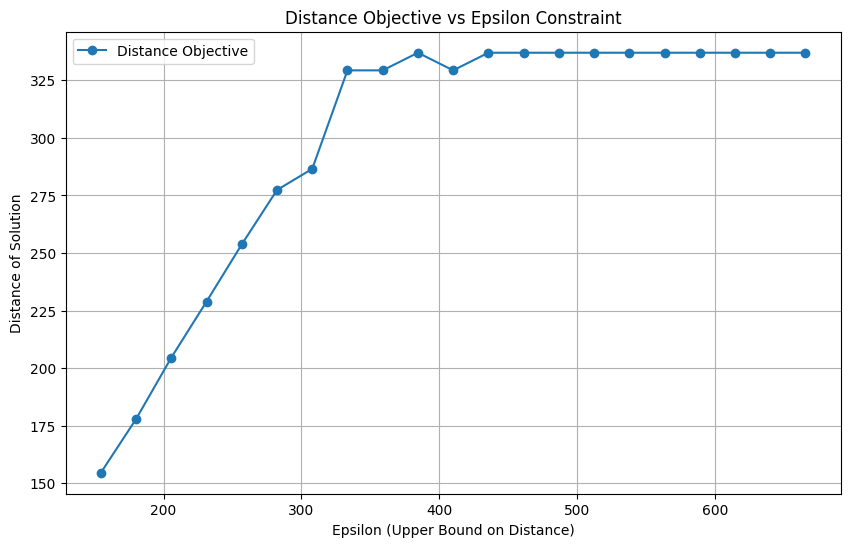

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(eps_values, distances_solution, marker='o', linestyle='-', label="Distance Objective")
plt.xlabel("Epsilon (Upper Bound on Distance)")
plt.ylabel("Distance of Solution")
plt.title("Distance Objective vs Epsilon Constraint")
plt.legend()
plt.grid()
plt.show()

In [32]:
solutions

[1.020199999999999,
 1.020199999999999,
 1.020199999999999,
 1.020199999999999,
 1.020199999999999,
 1.020199999999999,
 1.020199999999999,
 1.020199999999999,
 1.020199999999999,
 1.020199999999999,
 1.020199999999999,
 1.020199999999999,
 1.020199999999999,
 1.020199999999999,
 1.020199999999999,
 1.020199999999999,
 1.020199999999999,
 1.020199999999999,
 1.020199999999999,
 1.020199999999999,
 1.020199999999999,
 6.1574,
 3.4326000000000008,
 2.237799999999999,
 1.8709999999999996,
 1.4629999999999983,
 1.1147999999999998,
 1.105599999999999,
 1.020199999999999,
 1.020199999999999,
 1.0201999999999996,
 1.020199999999999,
 1.0201999999999996,
 1.0201999999999996,
 1.0201999999999996,
 1.0201999999999996,
 1.0201999999999996,
 1.0201999999999996,
 1.0201999999999996,
 1.0201999999999996,
 1.0201999999999996,
 1.0201999999999996]